In [1]:
%tensorflow_version 1.x
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import warnings
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D,Convolution2D,AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.merge import concatenate
from keras.models import Model
from keras import regularizers
from keras import initializers
from keras import backend as K
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory_root = '/content/drive/My Drive/Dataset tomat/'

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, tuple((224,224)))   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".png") == True or image_directory.endswith(".JPG") == True :
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Image loading completed


In [6]:
image_size = len(image_list)
image_size

1200

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list,image_labels, test_size=0.2 , random_state =42) 

[INFO] Spliting data to train, test


In [11]:
'''
Copyright 2017 TensorFlow Authors and Kent Sommer

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''



#########################################################################################
# Implements the Inception Network v4 (http://arxiv.org/pdf/1602.07261v1.pdf) in Keras. #
#########################################################################################

WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'


def preprocess_input(x):
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    x = np.multiply(x, 2.0)
    return x


def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x


def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)

    #Stem Block
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)

    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)

    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net


def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    '''
    Creates the inception v4 network

    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 224, 224))
    else:
        inputs = Input((224, 224, 3))

    # Make inception base
    x = inception_v4_base(inputs)


    # Final pooling and prediction
    if include_top:
      
        # Final pooling and prediction
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs, x, name='inception_v4')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
        else:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(weights_path, by_name=True)
    return model


def create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=False):
    return inception_v4(num_classes, dropout_prob, weights, include_top)
# ----------------------------------------------------------
incept_model = create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=False)
incept_model.load_weights('/content/drive/My Drive/input/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5')




for l in incept_model.layers: 
    if l is not None: l.trainable = True 
        
x = incept_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = BatchNormalization()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.2)(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=incept_model.input, outputs=predictions)        
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
_________

In [0]:
# #Define a function for a convolutional layer with batch normalization
# #The commands in this function will be used very much, so it's simpler to define this function once. 
# def conv(input_, filters_, kernel_, strides_, bias_, padding_):
#     conv_ = Conv2D(filters=filters_, kernel_size=kernel_, strides=strides_, use_bias=bias_, padding=padding_)(input_)
#     #The batch normalization helps to prevent overfitting and better learning results by removing the covariance shift.
#     conv_ = BatchNormalization(axis = -1, momentum = 0.9997, scale = False)(conv_)
#     conv_ = Activation("relu")(conv_)
#     return conv_

In [0]:
# #All kinds of inception networks starting with a stem. The stem preprocesses 
# #the input.
# def stem(input_):
#     #First convolutional block
#     stem_ = conv(input_, 32, (3,3), (2,2), False, "valid")
#     stem_ = conv(stem_, 32, (1,3), (1,1), False, "same")
#     stem_ = conv(stem_, 32, (3,1), (1,1), False, "same")
#     stem_ = conv(stem_, 64, (1,3), (1,1), False, "same")
#     stem_ = conv(stem_, 64, (3,1), (1,1), False, "same")
    
#     #Instead of going deeper the network will becoming wider!
#     stem_1 = conv(stem_, 96, (3,3), (2,2), False, "valid")
#     stem_2 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid")(stem_)
#     #Concatenate stem_1 and stem_2
#     stem_ = concatenate([stem_1, stem_2], axis = -1)
    
#     #In the next block we will also parallize two convolutional blocks
#     #Here I reuse the two variable names from above
#     stem_1 = conv(stem_, 64, (1,1), (1,1), False, "same")
#     stem_1 = conv(stem_1, 64, (7,1), (1,1), False, "same")
#     stem_1 = conv(stem_1, 64, (1,7), (1,1), False, "same")
#     stem_1 = conv(stem_1, 96, (1,3), (1,1), False, "valid")
#     stem_1 = conv(stem_1, 96, (3,1), (1,1), False, "valid")
#     stem_2 = conv(stem_, 64, (1,1), (1,1), False, "same")
#     stem_2 = conv(stem_2, 96, (3,3), (1,1), False, "valid")
#     #Concatenate stem_1 and stem_2
#     stem_ = concatenate([stem_1, stem_2], axis = -1)
    
#     #Third concatenation block
#     #Reuse stem_1 and stem_2
#     stem_1 = MaxPool2D(pool_size=(1,1), strides=(2,2), padding="valid")(stem_)
#     stem_2 = stem_1 = conv(stem_, 192, (3,3), (1,1), False, "valid")
#     #Concatenate stem_1 and stem_2
#     stem_ = concatenate([stem_1, stem_2], axis = -1)
    
#     return stem_  

In [0]:
# def inception_A(input_):
#     #In this block we parallize four convolutional blocks
#     #First
#     A_1 = conv(input_, 64, (1,1), (1,1), False, "same")
#     A_1 = conv(A_1, 96, (1,3), (1,1), False, "same")
#     A_1 = conv(A_1, 96, (3,1), (1,1), False, "same")
#     A_1 = conv(A_1, 96, (1,3), (1,1), False, "same")
    
    
#     #Second
#     A_2 = conv(input_, 64, (1,1), (1,1), False, "same")
#     A_2 = conv(A_2, 96, (1,3), (1,1), False, "same")
#     A_2 = conv(A_2, 96, (3,1), (1,1), False, "same")
    
#     #Third
#     A_3 = conv(input_, 96, (1,1), (1,1), False, "same")
    
#     #Fourth
#     A_4 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input_)
#     A_4 = conv(A_4, 96, (1,1), (1,1), False, "same")
    
#     A = concatenate([A_1, A_2, A_3, A_4], axis=-1)
    
#     return A    
    

In [0]:
# def inception_B(input_):
#     #Similiar to A
#     #In this block we also parallize four convolutional blocks
    
#     #First
#     B_1 = conv(input_, 192, (1,1), (1,1), False, "same")
#     B_1 = conv(B_1, 192, (1,7), (1,1), False, "same")
#     B_1 = conv(B_1, 224, (7,1), (1,1), False, "same")
#     B_1 = conv(B_1, 224, (1,7), (1,1), False, "same")
#     B_1 = conv(B_1, 256, (7,1), (1,1), False, "same")
    
#     #Second
#     B_2 = conv(input_, 192, (1,1), (1,1), False, "same")
#     B_2 = conv(B_2, 224, (7,1), (1,1), False, "same")
#     B_2 = conv(B_2, 256, (1,7), (1,1), False, "same")
    
#     #Third
#     B_3 = conv(input_, 384, (1,1), (1,1), False, "same")
    
#     #Fourth
#     B_4 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input_)
#     B_4 = conv(B_4, 128, (1,1), (1,1), False, "same")
    
#     B = concatenate([B_1, B_2, B_3, B_4], axis=-1)
    
#     return B    

In [0]:
# def inception_C(input_):
#     #This block is different to the structures of the other two blocks
    
#     #First
#     C_1 = conv(input_, 384, (1,1), (1,1), False, "same")
#     C_1 = conv(C_1, 448, (1,3), (1,1), False, "same")
#     C_1 = conv(C_1, 512, (3,1), (1,1), False, "same")
#     #Split it up again
#     C_11 = conv(C_1, 256, (1,3), (1,1), False, "same")
#     C_12 = conv(C_1, 256, (3,1), (1,1), False, "same")
#     #Concatenate it again
#     C_1 = concatenate([C_11, C_12], axis=-1)
    
#     #Second
#     C_2 = conv(input_, 384, (1,1), (1,1), False, "same")
#     #Split it up again
#     C_21 = conv(C_2, 256, (1,3), (1,1), False, "same")
#     C_22 = conv(C_2, 256, (3,1), (1,1), False, "same")
#     #Concatenate it again
#     C_2 = concatenate([C_21, C_22], axis=-1)
    
#     #Third
#     C_3 = conv(input_, 256, (1,1), (1,1), False, "same")
    
#     #Fourth
#     C_4 = AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(input_)
#     C_4 = conv(C_4, 128, (1,1), (1,1), False, "same")
    
#     C = concatenate([C_1, C_2, C_3, C_4], axis=-1)
    
#     return C

In [0]:
# def reduction_1(input_):
#     #Three parallized branches
#     #We must choose four parameters (k,l,m,n) depending on the used network
#     #The parameters are listed in a look up table in Paper 2
#     k = 192
#     l = 224
#     m = 256
#     n = 384
    
#     #First
#     R_1 = conv(input_, k, (1,1), (1,1), False, "same")
#     R_1 = conv(R_1, l, (1,3), (1,1), False, "same")
#     R_1 = conv(R_1, l, (3,1), (1,1), False, "same")
#     R_1 = conv(R_1, m, (3,3), (2,2), False, "same")
    
#     #Second
#     R_2 = conv(input_, n, (1,3), (2,2), False, "same")
#     R_2 = conv(input_, n, (3,1), (2,2), False, "same")
    
#     #Third
#     R_3 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")(input_)
    
#     R = concatenate([R_1, R_2, R_3], axis=-1)
    
#     return R

In [0]:
# def reduction_2(input_):
#     #Second reduction module
    
#     #First
#     R_1 = conv(input_, 256, (1,1), (1,1), False, "same")
#     R_1 = conv(R_1, 256, (1,7), (1,1), False, "same")
#     R_1 = conv(R_1, 320, (7,1), (1,1), False, "same")
#     R_1 = conv(R_1, 320, (3,3), (2,2), False, "same")
    
#     #Second
#     R_2 = conv(input_, 192, (1,1), (1,1), False, "same")
#     R_2 = conv(R_2, 192, (1,1), (2,2), False, "same")
    
#     #Third
#     R_3 = MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")(input_)
    
#     R = concatenate([R_1, R_2, R_3], axis=-1)
    
#     return R

In [0]:
# def pure_inception_v4(load_weights=True):
    
#     starter = Input((224, 224, 3))
    
#     #Start with the stem
#     inc = stem(starter)
    
#     #inception block A
#     inc = inception_A(inc)
#     inc = Dropout(0.2)(inc)
    
#     #First Reduction
#     inc = reduction_1(inc)
    
#     #innception block B
#     inc = inception_B(inc)    
#     inc = Dropout(0.2)(inc)
    
#     #Second Reduction
#     inc = reduction_2(inc)
    
#     #inception block C
#     inc = inception_C(inc)
    
#     #Average pooling
#     inc = AveragePooling2D((3, 3))(inc)

#     # Dropout
#     inc = Dropout(0.2)(inc) # Keep dropout 0.2 as mentioned in the paper
#     inc = Flatten()(inc)

#     # Output layer
#     output = Dense(units = 6 , activation = "softmax")(inc)
    
#     model = Model(starter, output, name = "Inception-v4")   
        
#     return model    


In [0]:
# Model = pure_inception_v4()

In [0]:
# print(Model.summary())

In [0]:
for layer in model.layers[:40]:
    layer.trainable=False
for layer in model.layers[40:]:
    layer.trainable=True

In [0]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.0001), metrics=['acc'])

In [0]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale


In [0]:
#Create the image generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=4)
val_generator = val_datagen.flow(x_test, y_test,batch_size=4)

In [0]:
%%time
#The training part
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(x_train) // 4,
                              epochs=50,
                              validation_data=val_generator)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
240/240 [==============================] - 74s 309ms/step - loss: 1.0877 - acc: 0.8694 - val_loss: 1.3012 - val_acc: 0.8319
Epoch 2/50
240/240 [==============================] - 47s 196ms/step - loss: 1.0463 - acc: 0.8851 - val_loss: 1.6046 - val_acc: 0.8035
Epoch 3/50
240/240 [==============================] - 47s 195ms/step - loss: 0.9954 - acc: 0.9069 - val_loss: 2.3816 - val_acc: 0.7292
Epoch 4/50
240/240 [==============================] - 47s 196ms/step - loss: 1.0024 - acc: 0.9087 - val_loss: 2.2675 - val_acc: 0.7292
Epoch 5/50
240/240 [==============================] - 47s 196ms/step - loss: 0.9858 - acc: 0.9170 - val_loss: 1.5096 - val_acc: 0.7208
Epoch 6/50
240/240 [==============================] - 47s 196ms/step - loss: 0.9814 - acc: 0.9182 - val_loss: 1.8841 - val_acc: 0.7167
Epoch 7/50
240/240 [==============================] - 47s 195ms/step - loss: 0.9590 - acc: 0.92

In [0]:
# aug = ImageDataGenerator(
#     rotation_range=25, width_shift_range=0.1,
#     height_shift_range=0.1, shear_range=0.2, 
#     zoom_range=0.2,horizontal_flip=True, 
#     fill_mode="nearest")

In [0]:
# Model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])

In [0]:
# history = Model.fit_generator(
#     aug.flow(x_train, y_train, batch_size=4),
#     steps_per_epoch=len(x_train)//4,
#     epochs=50,
#     validation_data=(x_test, y_test),
#     max_queue_size=4*2,
#     verbose=1
#     )

In [29]:
scores = model.evaluate(val_generator)
print(f"Test Accuracy: {scores[1]*100}") 


60/60 [==============================] - 3s 53ms/step
Test Accuracy: 72.9166567325592


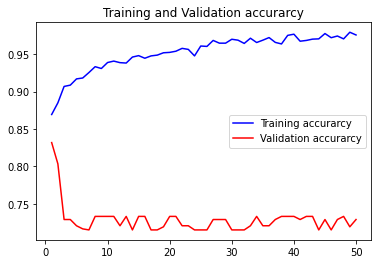

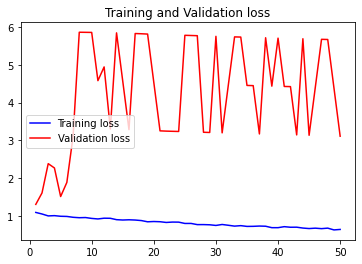

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()